# Машинное обучение, ЭФ МГУ

## Практическое задание 3. Линейные методы классификации. 

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
# пропишите путь до папки c данными:
DATA_PATH = '/Users/computer/Documents/Прак 3/data'

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [5]:
#your code here
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, KFold

cross_score_list = []
C_list = 10**np.linspace(-5, 5, 50)

for C in tqdm(C_list):
    cross_score = cross_val_score(estimator=LinearSVC(C=C), X=X_train, y=y_train, scoring='roc_auc', cv=KFold()).mean()
    cross_score_list.append(cross_score)

cross_score_list = np.array(cross_score_list)
C_best = C_list[np.argmax(cross_score_list)]
print('Наилучший параметр регуляризации:', C_best)


Наилучший параметр регуляризации: 3.2374575428176464


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

AUC-ROC на тесте: 0.84759
AUC-PR на тесте: 0.82963


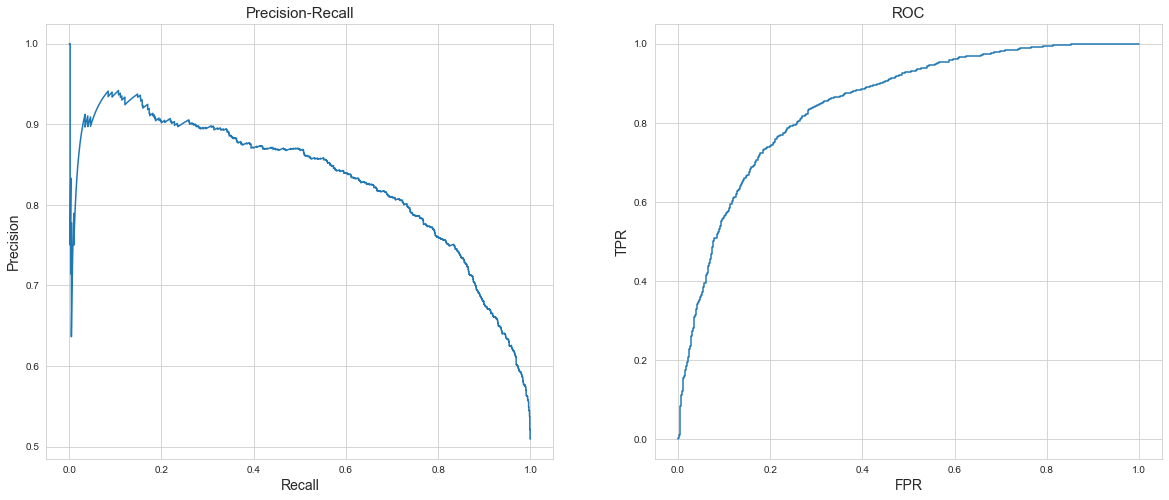

Различие метрик в том, что метрика AUC-PR чаще используется при выраженном дисбалансе классов
Результаты метрик схожи, обе ~0.83. В выборке нет ярковыраженного класса, поэтому метрики показали 
примерно одинаковый результат


In [6]:
#your code here
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

model = LinearSVC(C=C_best)
model.fit(X_train, y_train)

precision, recall, thresholds_pr = precision_recall_curve(y_true=y_test, probas_pred=model.decision_function(X_test))
FPR, TPR, thresholds_roc = roc_curve(y_true=y_test, y_score=model.decision_function(X_test))

AUC_ROC = roc_auc_score(y_true=y_test, y_score=model.decision_function(X_test))
AUC_PR = auc(recall, precision)

print('AUC-ROC на тесте:', round(AUC_ROC, 5))
print('AUC-PR на тесте:', round(AUC_PR, 5))

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].set_title('Precision-Recall', fontsize=15)
ax[0].plot(recall, precision)
ax[0].set_ylabel('Precision', fontsize=14)
ax[0].set_xlabel('Recall', fontsize=14)
ax[1].set_title('ROC', fontsize=15)
ax[1].plot(FPR, TPR)
ax[1].set_ylabel('TPR', fontsize=14)
ax[1].set_xlabel('FPR', fontsize=14)
plt.show()

print('Различие метрик в том, что метрика AUC-PR чаще используется при выраженном дисбалансе классов')
print('Результаты метрик схожи, обе ~0.83. В выборке нет ярковыраженного класса, поэтому метрики показали',
      '\nпримерно одинаковый результат')

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).


Наилучший параметр регуляризации: 5.1794746792312125
AUC-ROC на тесте: 0.84788
AUC-PR на тесте: 0.82912


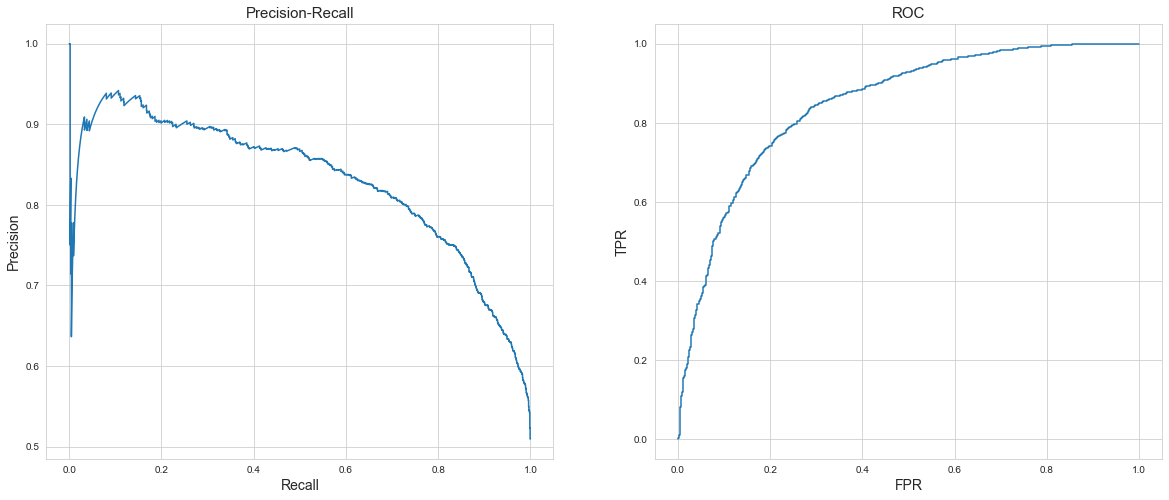

Метрики качества SVM и LR примерно равны (совпадают до второго знака после запятой)


In [7]:
#your code here
from sklearn.linear_model import LogisticRegression

cross_score_list = []
C_list = 10**np.linspace(-5, 5, 50)

for C in tqdm(C_list):
    cross_score = cross_val_score(estimator=LogisticRegression(penalty='l2', C=C), X=X_train, y=y_train
                                  , scoring='roc_auc', cv=KFold()).mean()
    cross_score_list.append(cross_score)

cross_score_list = np.array(cross_score_list)
C_best = C_list[np.argmax(cross_score_list)]
print('Наилучший параметр регуляризации:', C_best)


model = LogisticRegression(penalty='l2', C=C_best)
model.fit(X_train, y_train)

precision, recall, thresholds_pr = precision_recall_curve(y_true=y_test, probas_pred=model.decision_function(X_test))
FPR, TPR, thresholds_roc = roc_curve(y_true=y_test, y_score=model.decision_function(X_test))

AUC_ROC = roc_auc_score(y_true=y_test, y_score=model.decision_function(X_test))
AUC_PR = auc(recall, precision)

print('AUC-ROC на тесте:', round(AUC_ROC, 5))
print('AUC-PR на тесте:', round(AUC_PR, 5))

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].set_title('Precision-Recall', fontsize=15)
ax[0].plot(recall, precision)
ax[0].set_ylabel('Precision', fontsize=14)
ax[0].set_xlabel('Recall', fontsize=14)
ax[1].set_title('ROC', fontsize=15)
ax[1].plot(FPR, TPR)
ax[1].set_ylabel('TPR', fontsize=14)
ax[1].set_xlabel('FPR', fontsize=14)
plt.show()

print('Метрики качества SVM и LR примерно равны (совпадают до второго знака после запятой)')

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

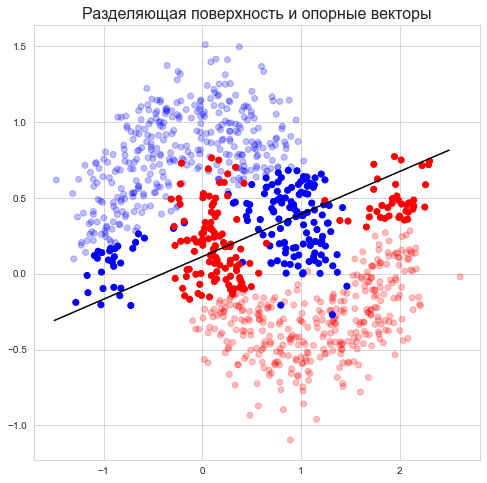

In [8]:
#your code here
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.2)
model = SVC(kernel='linear')
model.fit(X, y)

sup_vecs = model.support_vectors_
k = -model.coef_[0][0]/model.coef_[0][1]
b = -model.intercept_[0]/model.coef_[0][1]

plt.scatter(X[:, 0], X[:, 1], color=np.array(['blue', 'red'])[y], alpha=0.25)
plt.scatter(sup_vecs[:, 0], sup_vecs[:, 1], color=np.array(['blue', 'red'])[y[model.support_]])
plt.plot([-1.5, 2.5], k * np.array([-1.5, 2.5]) + b, color='black')
plt.title('Разделяющая поверхность и опорные векторы', fontsize=16)
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plot_2d_separator` (реализованная ниже).

In [9]:
def plot_2d_separator(clf: object, X: np.array, y: np.array=None, draw_points: bool=True, **kwargs):
    min_x, max_x, min_y, max_y = (
        np.min(X[:, 0]), np.max(X[:, 0]), np.min(X[:, 1]), np.max(X[:, 1])
    )
    std_x, std_y = np.std(X[:, 0]), np.std(X[:, 1])
    x, y_ = np.meshgrid(
        np.linspace(min_x - 0.1*std_x, max_x + 0.1*std_x, 200), 
        np.linspace(min_x - 0.1*std_x, max_x + 0.1*std_x, 200)
    )
    z = np.zeros_like(x)
    if hasattr(clf, 'predict_proba'):
        for i in tqdm(range(x.shape[0])):
            for j in range(x.shape[1]):
                z[i, j] = clf.predict_proba([[x[i, j], y_[i, j]]])[:, 1].item()
    else:
        for i in tqdm(range(x.shape[0])):
            for j in range(x.shape[1]):
                z[i, j] = clf.decision_function([[x[i, j], y_[i, j]]]).item()
    z = z[:-1, :-1]
    z -= z.mean() # чтобы было 2 цвета
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    plt.pcolor(x, y_, z, cmap='coolwarm', vmin=z_min, vmax=z_max);
    if draw_points:
        if y is None:
            plt.scatter(X[:, 0], X[:, 1], **kwargs);
        else:
            if 'color' in kwargs:
                del kwargs['color']
            plt.scatter(X[:, 0], X[:, 1], color=np.array(['blue', 'red'])[y], **kwargs);


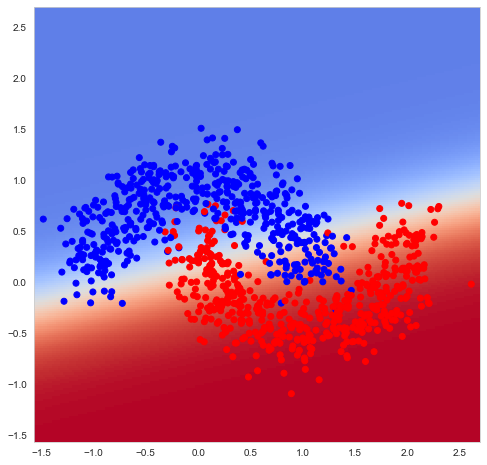

In [10]:
model = LogisticRegression()
model.fit(X, y)
plot_2d_separator(clf=model, X=X, y=y, draw_points=True)

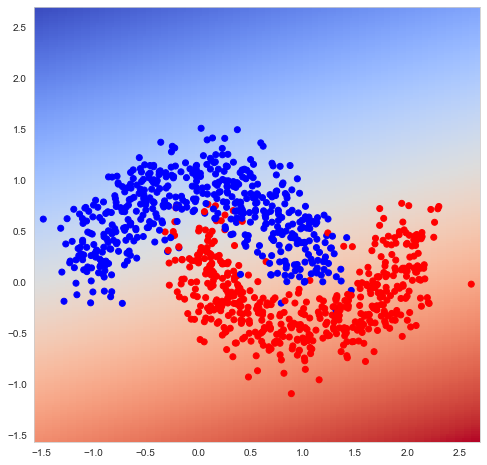

In [11]:
model = SVC(kernel='linear')
model.fit(X, y)
plot_2d_separator(clf=model, X=X, y=y, draw_points=True)

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [12]:
def plot_calibration_curve(y_test, preds, label: str=None, color: str='blue'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.plot(bin_middle_points, bin_real_ratios, label=label, color=color)
    plt.scatter(bin_middle_points, bin_real_ratios, color=color)
    if label is not None:
        plt.legend(fontsize=13);
    plt.ylim([-0.05, 1.05])
    plt.grid(True)

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы, например можете использовать `plt.hist` или `sns.distplot`). Чем они различаются? Чем вы можете объяснить это?

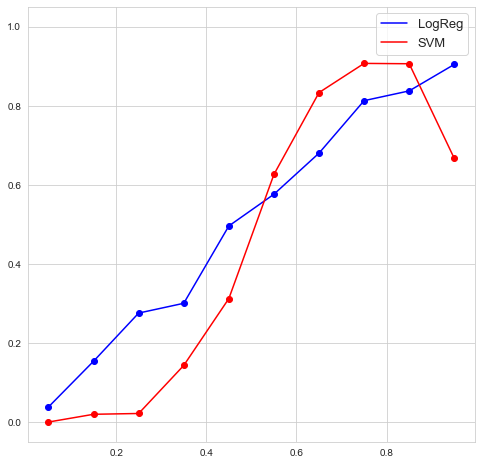

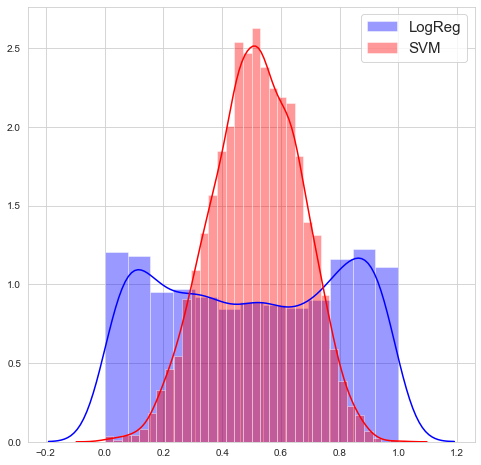

In [13]:
#your code here
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
pred_LR = model_LR.predict_proba(X_test)[:, 1]

model_SVM = LinearSVC()
model_SVM.fit(X_train, y_train)
pred_SVM_ = model_SVM.decision_function(X_test)
#pred_SVM_ = np.abs(model_SVM.decision_function(X_test))
#переводим в отрезок [0;1]
pred_SVM = (pred_SVM_ - pred_SVM_.min()) / (pred_SVM_.max() - pred_SVM_.min())

plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test=y_test, preds=pred_LR, label='LogReg')
plot_calibration_curve(y_test=y_test, preds=pred_SVM, color='red', label='SVM')

plt.figure(figsize=(8, 8))
sns.distplot(pred_LR, color='blue', label='LogReg')
sns.distplot(pred_SVM, color='red', label='SVM');
plt.legend(fontsize=15);

Предсказания LogReg распределены равномерно с небольшим увеличением в сторону 0 и 1, предсказания SVM распределены нормально. Это можно объяснить тем, что логистическая регрессия при верной оценке признаков сильнее стремится к 0 и 1, чем метод опорных векторов. К тому же, в SVM мы margin использовали в качестве вероятности, поэтому чем дальше от 0.5 значения, тем дальше расположены объекты от разделяющей поверхности. С увеличением расстояния увеличивается и вероятность отнесения методом опорных векторов объекта к классу.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

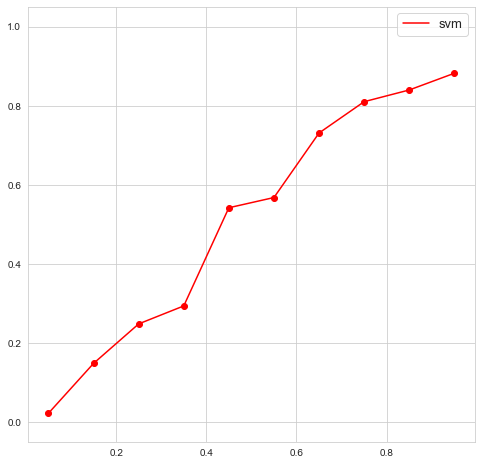

In [14]:
# your code here
from sklearn.calibration import CalibratedClassifierCV

model_svm_calibr = CalibratedClassifierCV(base_estimator=SVC(kernel='linear'))
model_svm_calibr.fit(X_train, y_train)

plot_calibration_curve(y_test=y_test, preds=model_svm_calibr.predict_proba(X_test)[:, 1], color='red', label='svm')

Кривая улучшилась, так как стала более диагональной

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [15]:
#your code here


# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [16]:
df = pd.read_csv(f'{DATA_PATH}/bank-additional-full.csv', sep=';')
df.drop(['duration'], axis=1, inplace=True)

In [17]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__age__ (numeric)

__job__ : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

__marital__ : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

__education__ (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

__default__: has credit in default? (categorical: "no","yes","unknown")

__housing__: has housing loan? (categorical: "no","yes","unknown")

__loan__: has personal loan? (categorical: "no","yes","unknown")
### related with the last contact of the current campaign:
__contact__: contact communication type (categorical: "cellular","telephone") 

__month__: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

__day_of_week__: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

__duration__: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
__campaign__: number of contacts performed during this campaign and for this client (numeric, includes last contact)

__pdays__: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

__previous__: number of contacts performed before this campaign and for this client (numeric)

__poutcome__: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
### social and economic context attributes
__emp.var.rate__: employment variation rate - quarterly indicator (numeric)

__cons.price.idx__: consumer price index - monthly indicator (numeric)     
__cons.conf.idx__: consumer confidence index - monthly indicator (numeric)     
__euribor3m__: euribor 3 month rate - daily indicator (numeric)

__nr.employed__: number of employees - quarterly indicator (numeric)

### Output variable (desired target):

__y__ - has the client subscribed a term deposit? (binary: "yes","no")

__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [237]:
#your code here
from sklearn.model_selection import train_test_split
RANDOM_STATE = 777
df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['y'].values, random_state=RANDOM_STATE)
y_train = (df_train['y'].values == 'yes').astype(int)
y_test = (df_test['y'].values == 'yes').astype(int)
print(df_train.shape, df_test.shape)

(30891, 21) (10297, 21)


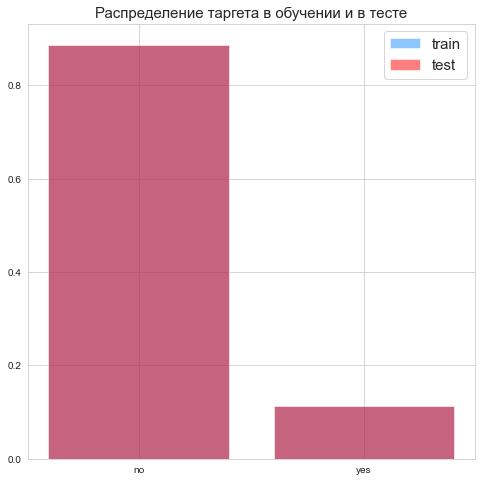

In [19]:
# Проверка, что данные разделились с одинаковым распределением таргета
tmp_train = df_train['y'].value_counts(1).to_dict()
tmp_test = df_test['y'].value_counts(1).to_dict()
plt.title(f'Распределение таргета в обучении и в тесте', fontsize=15);
plt.bar(['no', 'yes'], [tmp_train['no'], tmp_train['yes']], color='dodgerblue', alpha=0.5, label='train');
plt.bar(['no', 'yes'], [tmp_test['no'], tmp_test['yes']], color='red', alpha=0.5, label='test');
plt.legend(fontsize=15);

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: AUC-PR позволяет получить качественные предсказания при дисбалансе классов в выборке. У нас довольно якровыраженный дисбаланс (доля 'yes' - 11% выборки)

In [20]:
#your code here
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import auc, precision_recall_curve

X_train = df_train.drop(['y'], axis=1).copy()
X_test = df_test.drop(['y'], axis=1).copy()

for feature in X_train.columns[(X_train.dtypes == 'object')]:
    ordinal_enc = OrdinalEncoder()
    ordinal_enc.fit(X_train[feature].values.reshape(-1, 1))
    X_train[feature] = ordinal_enc.transform(X_train[feature].values.reshape(-1, 1))
    X_test[feature] = ordinal_enc.transform(X_test[feature].values.reshape(-1, 1))
    
    
model = LogisticRegression()
model.fit(X_train, y_train)

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

AUC-PR на тесте: 0.415468520503827


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [21]:
#your code here
#your code here
import time
from itertools import chain
from sklearn.preprocessing import OneHotEncoder

X_train = df_train.drop(['y'], axis=1).copy()
X_test = df_test.drop(['y'], axis=1).copy()
cat_cols = X_train.columns[X_train.dtypes == 'object'].values
noncat_cols = X_train.columns[X_train.dtypes != 'object'].values

st = time.perf_counter() 
ohe_enc = OneHotEncoder()
ohe_enc.fit(X_train[cat_cols])
cat_ohe_names = list(chain.from_iterable(
    [[f'{col}_{category}' for category in ohe_enc.categories_[i]] for i, col in 
     enumerate(cat_cols)]
))

X_train = pd.concat([
    X_train[noncat_cols].reset_index(drop=True),
    pd.DataFrame(ohe_enc.transform(X_train[cat_cols]).toarray(), 
                 columns=cat_ohe_names)
], axis=1)

X_test = pd.concat([
    X_test[noncat_cols].reset_index(drop=True),
    pd.DataFrame(ohe_enc.transform(X_test[cat_cols]).toarray(), 
                 columns=cat_ohe_names)
], axis=1)

end = time.perf_counter() - st
print(f'OneHotEnc обучился и применился за {end // 60} минут {round(end % 60, 2)} секунд')
    
    
st = time.perf_counter() 
model = LogisticRegression()
model.fit(X_train, y_train)
end = time.perf_counter() - st
print(f'Модель обучилась за {end // 60} минут {round(end % 60, 2)} секунд')

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

OneHotEnc обучился и применился за 0.0 минут 0.13 секунд
Модель обучилась за 0.0 минут 0.41 секунд
AUC-PR на тесте: 0.43502161858585575


Качество модели заметно улучшилось, 0.415->0.435 

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?

In [22]:
#your code here
X_train = df_train.drop(['y'], axis=1).copy()
X_test = df_test.drop(['y'], axis=1).copy()
y_train = (df_train['y'].values == 'yes').astype(int)
y_test = (df_test['y'].values == 'yes').astype(int)
cat_cols = X_train.columns[X_train.dtypes == 'object'].values

st = time.perf_counter()

df_train_y = df_train.copy()
df_train_y['y'] = y_train
df_test_y = df_test.copy()
df_test_y['y'] = y_test

for col in cat_cols:
    X_train[col] = df_train_y[col].map(df_train_y.groupby(col)['y'].mean())
    X_test[col] = df_test_y[col].map(df_test_y.groupby(col)['y'].mean())

end = time.perf_counter() - st
print(f'Метод счётчиков обучился и применился за {end // 60} минут {round(end % 60, 2)} секунд')
    
    
st = time.perf_counter() 
model = LogisticRegression()
model.fit(X_train, y_train)
end = time.perf_counter() - st
print(f'Модель обучилась за {end // 60} минут {round(end % 60, 2)} секунд')

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Метод счётчиков обучился и применился за 0.0 минут 0.17 секунд
Модель обучилась за 0.0 минут 0.41 секунд
AUC-PR на тесте: 0.41736273057923784


Модель обучилась быстрее, поскольку мы теперь храним n столбцов, а не k*n, как при one-hot-encoding (k - кол-во уникальных значений в каждом столбце). Но показатель AUC-PR стал хуже (снизился с 0,435 до 0.417).

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6. (1 балл)__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [62]:
#your code here
X_train = df_train.drop(['y'], axis=1).copy()
X_test = df_test.drop(['y'], axis=1).copy()
y_train = (df_train['y'].values == 'yes').astype(int)
y_test = (df_test['y'].values == 'yes').astype(int)
cat_cols = X_train.columns[X_train.dtypes == 'object'].values

st = time.perf_counter()

df_train_y = df_train.copy()
df_train_y['y'] = y_train
df_test_y = df_test.copy()
df_test_y['y'] = y_test


np.random.seed(13)
for col in cat_cols:
    X_train[col] = df_train_y[col].map(df_train_y.groupby(col)['y'].mean()) + np.random.normal(0,0.08,X_train[col].shape)
    X_test[col] = df_test_y[col].map(df_test_y.groupby(col)['y'].mean()) + np.random.normal(0,0.08,X_test[col].shape)

end = time.perf_counter() - st
print(f'Метод счётчиков с шумом обучился и применился за {end // 60} минут {round(end % 60, 2)} секунд')


st = time.perf_counter() 
model = LogisticRegression()
model.fit(X_train, y_train)
end = time.perf_counter() - st
print(f'Модель обучилась за {end // 60} минут {round(end % 60, 2)} секунд')

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Метод счётчиков с шумом обучился и применился за 0.0 минут 0.11 секунд
Модель обучилась за 0.0 минут 0.24 секунд
AUC-PR на тесте: 0.42542972937325474


Модель почти улучшилась в качестве (AUC-PR 0.417->0.425).
Прогоняя ячейку несколько раз, можно добиться как ухудшения, так и улучшения качества - всё зависит от конкретной генерации случайных величин. При удачно подобранном сиде, качество растет.
На мой взгляд, это показывает, что шум не помогает корректировать результат применения счетчиков. Тем не менее, подобрать удачный seed всё-таки можно

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [271]:
#your code here
X_train = df_train.drop(['y'], axis=1).copy()
X_test = df_test.drop(['y'], axis=1).copy()
y_train = (df_train['y'].values == 'yes').astype(int)
y_test = (df_test['y'].values == 'yes').astype(int)
cat_cols = X_train.columns[X_train.dtypes == 'object'].values

st = time.perf_counter()

df_train_y = df_train.copy()
df_train_y['y'] = y_train
df_test_y = df_test.copy()
df_test_y['y'] = y_test

global_mean = 0.15#df_train_y['y'].mean()
C = 20
for col in cat_cols:
    X_train[col] = (df_train_y[col].map(df_train_y.groupby(col)['y'].sum()) + C*global_mean) / (df_train_y[col].map(df_train_y.groupby(col).size()) + C)
    X_test[col] = (df_test_y[col].map(df_test_y.groupby(col)['y'].sum()) + C*global_mean) / (df_test_y[col].map(df_test_y.groupby(col).size()) + C)

end = time.perf_counter() - st
print(f'Метод счётчиков обучился и применился за {end // 60} минут {round(end % 60, 2)} секунд')
    
    
st = time.perf_counter() 
model = LogisticRegression()
model.fit(X_train, y_train)
end = time.perf_counter() - st
print(f'Модель обучилась за {end // 60} минут {round(end % 60, 2)} секунд')

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Метод счётчиков обучился и применился за 0.0 минут 0.18 секунд
Модель обучилась за 0.0 минут 0.22 секунд
AUC-PR на тесте: 0.4246933881269409


Метрика качества улучшилась по сравнению с обычным счетчиком.

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [74]:
#your code here
X_train = df_train.drop(['y'], axis=1).copy()
X_test = df_test.drop(['y'], axis=1).copy()
y_train = (df_train['y'].values == 'yes').astype(int)
y_test = (df_test['y'].values == 'yes').astype(int)
cat_cols = np.append(X_train.columns[X_train.dtypes == 'object'].values, 'age')

st = time.perf_counter()

df_train_y = df_train.copy()
df_train_y['y'] = y_train
df_test_y = df_test.copy()
df_test_y['y'] = y_test

for col in cat_cols:
    X_train[col] = df_train_y[col].map(df_train_y.groupby(col)['y'].mean())
    X_test[col] = df_test_y[col].map(df_test_y.groupby(col)['y'].mean())

end = time.perf_counter() - st
print(f'Метод счётчиков (+age) обучился и применился за {end // 60} минут {round(end % 60, 2)} секунд')
    
    
st = time.perf_counter() 
model = LogisticRegression()
model.fit(X_train, y_train)
end = time.perf_counter() - st
print(f'Модель обучилась за {end // 60} минут {round(end % 60, 2)} секунд')

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Метод счётчиков (+age) обучился и применился за 0.0 минут 0.08 секунд
Модель обучилась за 0.0 минут 0.14 секунд
AUC-PR на тесте: 0.4071477996424665


Модель стала хуже бейзлайна счетчиков (AUC-PR 0.417->0.407)

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [90]:
#your code here
X_train = df_train.drop(['y'], axis=1).copy()
X_test = df_test.drop(['y'], axis=1).copy()
y_train = (df_train['y'].values == 'yes').astype(int)
y_test = (df_test['y'].values == 'yes').astype(int)

months_dict = dict({'jan':0,'fev':1,'mar':2,'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':9,'nov':10,'dec':11})
days_dict = dict({'mon':0,'tue':1,'wed':2,'thu':3,'fri':4,'sat':5,'sun':6})
X_train['month'] = X_train['month'].map(months_dict).values
X_test['month']= X_test['month'].map(months_dict).values
X_train['day_of_week'] = X_train['day_of_week'].map(days_dict).values
X_test['day_of_week']= X_test['day_of_week'].map(days_dict).values

cat_cols = X_train.columns[X_train.dtypes == 'object'].values

st = time.perf_counter()

df_train_y = df_train.copy()
df_train_y['y'] = y_train
df_test_y = df_test.copy()
df_test_y['y'] = y_test

for col in cat_cols:
    X_train[col] = df_train_y[col].map(df_train_y.groupby(col)['y'].mean())
    X_test[col] = df_test_y[col].map(df_test_y.groupby(col)['y'].mean())

end = time.perf_counter() - st
print(f'Метод счётчиков (день и месяц как числа) обучился и применился за {end // 60} минут {round(end % 60, 2)} секунд')
    
    
st = time.perf_counter() 
model = LogisticRegression()
model.fit(X_train, y_train)
end = time.perf_counter() - st
print(f'Модель обучилась за {end // 60} минут {round(end % 60, 2)} секунд')

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Метод счётчиков (день и месяц как числа) обучился и применился за 0.0 минут 0.06 секунд
Модель обучилась за 0.0 минут 0.17 секунд
AUC-PR на тесте: 0.40630399519349736


Модель по-прежнему не улучшается, мало того, она стала еще хуже

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Плюсы заключаются в более быстрой обработке данных и обучении модели, также задействуется меньше памяти. Также плюс в гибкости алгоритма, можно подстраивать его под выборку, возможно комбинируя несколько методов сразу.
Минусы в том, что one-hot-кодирование дало лучший результат, чем все остальные варианты счетчиков. Соответственно, чтобы грамотно воспользоваться методом счетчиков нужно перебирать различные варианты, что сильно затрудняет задачу

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [190]:
df = pd.read_csv(f'{DATA_PATH}/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [191]:
#your code here
ohe_enc = OneHotEncoder()
cat_cols = X_train.columns[X_train.dtypes == 'object'].values
noncat_cols = X_train.columns[X_train.dtypes != 'object'].values
ohe_enc.fit(X_train[cat_cols])
cat_ohe_names = list(chain.from_iterable(
    [[f'{col}_{category}' for category in ohe_enc.categories_[i]] for i, col in 
     enumerate(cat_cols)]
))

X_train = pd.concat([
    X_train[noncat_cols].reset_index(drop=True),
    pd.DataFrame(ohe_enc.transform(X_train[cat_cols]).toarray(), 
                 columns=cat_ohe_names)
], axis=1)

X_test = pd.concat([
    X_test[noncat_cols].reset_index(drop=True),
    pd.DataFrame(ohe_enc.transform(X_test[cat_cols]).toarray(), 
                 columns=cat_ohe_names)
], axis=1)
print(X_train.shape[1])

62


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [130]:
#your code here
model = LogisticRegression()
model.fit(X_train, y_train)

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model.predict_proba(X_test)[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

AUC-PR на тесте: 0.42921692706402614


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8 (0.9 балла = 0.3 * 3).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [131]:
#your code here
st = time.perf_counter()

coef = model.coef_.reshape(X_train.columns.shape)
df_feature = pd.DataFrame({'feature': X_train.columns, 'coef': abs(coef)})
top_cols = df_feature.sort_values(by='coef', ascending=False)['feature'].tolist()[:40]

end = time.perf_counter() - st

print(f'Признаки отобрались за {end // 60} минут {round(end % 60, 2)} секунд')

model_LR = LogisticRegression()
model_LR.fit(X_train[top_cols], y_train)

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model_LR.predict_proba(X_test[top_cols])[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Признаки отобрались за 0.0 минут 0.0 секунд
AUC-PR на тесте: 0.4404516521807636


Качество модели улучшилось, стало лучше, чем при использовании обычного one-hot-кодирования (AUC-PR 0.429->0.440)

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [195]:
#your code here
from sklearn.preprocessing import Normalizer

X_train_norm1 = X_train.copy()
X_test_norm1 = X_test.copy()

X_train_norm1[noncat_cols] = Normalizer().fit_transform(X_train[noncat_cols])
X_test_norm1[noncat_cols] = Normalizer().fit_transform(X_test[noncat_cols])

model = LogisticRegression()
model.fit(X_train_norm1, y_train)

coef = model.coef_.reshape(X_train.columns.shape)
df_feature = pd.DataFrame({'feature': X_train.columns, 'coef': abs(coef)})
top_cols_norm1 = df_feature.sort_values(by='coef', ascending=False)['feature'].tolist()[:40]

model_LR = LogisticRegression()
model_LR.fit(X_train_norm1[top_cols_norm1], y_train)

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model_LR.predict_proba(X_test_norm1[top_cols_norm1])[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

all(x == y for x,y in zip(top_cols,top_cols_norm1))

AUC-PR на тесте: 0.40925178122725925


False

Качество модели ухудшилось, несмотря на нормирование признаков. Признаки поменялись

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [202]:
#your code here
from sklearn.preprocessing import Normalizer

X_train_norm = pd.DataFrame(Normalizer().fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(Normalizer().fit_transform(X_test), columns=X_test.columns)

model = LogisticRegression()
model.fit(X_train_norm, y_train)

coef = model.coef_.reshape(X_train.columns.shape)
df_feature = pd.DataFrame({'feature': X_train_norm.columns, 'coef': abs(coef)})
top_cols_norm2 = df_feature.sort_values(by='coef', ascending=False)['feature'].tolist()[:40]

model_LR = LogisticRegression()
model_LR.fit(X_train_norm[top_cols_norm2], y_train)

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model_LR.predict_proba(X_test[top_cols_norm2])[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

print(all(x == y for x,y in zip(top_cols,top_cols_norm2)))
print(all(x == y for x,y in zip(top_cols_norm1,top_cols_norm2)))

AUC-PR на тесте: 0.4716135069891795
False
False


Топ-40 изменился еще раз. При этом выросло качество (AUC-PR 0.440->0.472)

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [174]:
#your code here
st = time.perf_counter()

y_train_t_stat = np.array(y_train)
y_test_t_stat = np.array(y_test)

def t_stat(X, y, feat):
    a = abs(X[y == 1][feat].mean() - X[y == 0][feat].mean())
    b = len(X[y == 1][feat]) * X[y == 1][feat].var() + len(X[y == 0][feat]) * X[y == 0][feat].var()
    c = len(X[feat])
    return a / ((b / c) ** 0.5)

t_stat_cols= [t_stat(X=X_train, y=y_train_t_stat, feat=col) for col in X_train]
df_feature = pd.DataFrame({'feature': X_train.columns, 't': t_stat_cols})
top_cols_t = df_feature.sort_values(by='t', ascending=False)['feature'].tolist()[:40]

end = time.perf_counter() - st
print(f'Отбор с помощью t-статистик применился за {end // 60} минут {round(end % 60, 2)} секунд')

model_LR_t = LogisticRegression()
model_LR_t.fit(X_train[top_cols_t], y_train)

pr, rec, thresholds = precision_recall_curve(y_true=y_test, probas_pred=model_LR_t.predict_proba(X_test[top_cols_t])[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Отбор с помощью t-статистик применился за 0.0 минут 1.55 секунд
AUC-PR на тесте: 0.4297729555111686


Качество ниже, чем при отборе признаков с наибольшим модулем соответствующего параметра линейной модели. Также сильно увеличилось время отбора признаков 

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [233]:
#your code here
st = time.perf_counter()

X_tr_tr, X_tr_val, y_tr_tr, y_tr_val = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train)

X_tr = X_tr_tr.copy()
X_val = X_tr_val.copy()
auc_before = 0
auc_after = 0
feat_num = X_tr.shape[1]
while feat_num > 40 and auc_before <= auc_after + 0.01:
    auc_list = []
    feat_list = X_tr.columns
    if X_tr.shape[1] == X_tr_tr.shape[1]:
        model_LR = LogisticRegression()
        model_LR.fit(X_tr, y_tr_tr)

        pr, rec, thresholds = precision_recall_curve(y_true=y_tr_val, probas_pred=model_LR.predict_proba(X_val)[:, 1])
        auc_before = auc(rec, pr)
    else:
        auc_before = auc_after
    
    for feat in tqdm(feat_list):
        
        X_tr_no_feat = X_tr.drop([feat], axis=1).copy()
        X_val_no_feat = X_val.drop([feat], axis=1).copy()
        
        model_LR = LogisticRegression()
        model_LR.fit(X_tr_no_feat, y_tr_tr)

        pr, rec, thresholds = precision_recall_curve(y_true=y_tr_val
                                                     , probas_pred=model_LR.predict_proba(X_val_no_feat)[:, 1])
        auc_list.append(auc(rec, pr))
    
    auc_after = np.max(auc_list)
    feat_exclud = feat_list[np.argmax(auc_list)]
    X_tr = X_tr.drop([feat_exclud], axis=1)
    X_val = X_val.drop([feat_exclud], axis=1)
    feat_num = X_tr.shape[1]
    feat_list = X_tr.columns

end = time.perf_counter() - st
print(f'Метод-обёртка применился за {end // 60} минут {round(end % 60, 2)} секунд')

model_LR = LogisticRegression()
model_LR.fit(X_tr, y_tr_tr)

pr, rec, thresholds = precision_recall_curve(y_true=y_tr_val, probas_pred=model_LR.predict_proba(X_tr_val[feat_list])[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)


Метод-обёртка применился за 7.0 минут 27.86 секунд
AUC-PR на тесте: 0.44166177322153743
Wall time: 7min 28s


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [91]:
#your code here
X_tr = X_tr_tr.copy()
X_val = X_tr_val.copy()
auc_before = 0
auc_after = 0
feat_num = X_tr.shape[1]
while feat_num <= 40 and auc_before <= auc_after + 0.01:
    auc_list = []
    feat_list = X_tr.columns
    if X_tr.shape[1] == 1:
        model_LR = LogisticRegression()
        model_LR.fit(X_tr, y_tr_tr)

        pr, rec, thresholds = precision_recall_curve(y_true=y_tr_val, probas_pred=model_LR.predict_proba(X_val)[:, 1])
        auc_before = auc(rec, pr)
    else:
        auc_before = auc_after
    
    for feat in tqdm(feat_list):
        
        X_tr_no_feat = X_tr.drop([feat], axis=1).copy()
        X_val_no_feat = X_val.drop([feat], axis=1).copy()
        
        model_LR = LogisticRegression()
        model_LR.fit(X_tr_no_feat, y_tr_tr)

        pr, rec, thresholds = precision_recall_curve(y_true=y_tr_val
                                                     , probas_pred=model_LR.predict_proba(X_val_no_feat)[:, 1])
        auc_list.append(auc(rec, pr))
    
    auc_after = np.max(auc_list)
    feat_exclud = feat_list[np.argmax(auc_list)]
    X_tr = X_tr.drop([feat_exclud], axis=1)
    X_val = X_val.drop([feat_exclud], axis=1)
    feat_num = X_tr.shape[1]
    feat_list = X_tr.columns

end = time.perf_counter() - st
print(f'Метод-обёртка применился за {end // 60} минут {round(end % 60, 2)} секунд')

model_LR = LogisticRegression()
model_LR.fit(X_tr, y_tr_tr)

pr, rec, thresholds = precision_recall_curve(y_true=y_tr_val, probas_pred=model_LR.predict_proba(X_tr_val[feat_list])[:, 1])

print(
    'AUC-PR на тесте:',
    #your code here
    auc(rec, pr)
)

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Существенный недостаток - огромное количество времени, которое необходимо для выполнения кода.
Преимущества в том, что мы отбираем наилучшие параметры на каждом шаге.
Однако при этом возникает другая проблема, возможно, следовало бы убрать сразу два признака и тогда дальнейший AUC-PR начал расти невероятно быстро. Но итеративность процесса так поступить не позволяет.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе. А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [264]:
df = pd.read_csv(f'{DATA_PATH}/bank-additional-full.csv', sep=';')

#your code here
from sklearn.model_selection import KFold

rev = []
wage = []
kf =  KFold (n_splits = 5, shuffle = True, random_state = 500)
for ind in kf.split(df):
    df_train=df.iloc[ind[0]]
    df_test=df.iloc[ind[1]]
    X_train = df_train.drop(['y'], axis=1).copy()
    X_test = df_test.drop(['y'], axis=1).copy()
    y_train = (df_train['y'].values == 'yes').astype(int)
    y_test = (df_test['y'].values == 'yes').astype(int)
    
    cat_cols = X_train.columns[X_train.dtypes == 'object'].values
    noncat_cols = X_train.columns[X_train.dtypes != 'object'].values
    
    ohe_enc = OneHotEncoder()
    ohe_enc.fit(X_train[cat_cols])
    
    cat_ohe_names = list(chain.from_iterable(
        [[f'{col}_{category}' for category in ohe_enc.categories_[i]] for i, col in enumerate(cat_cols)]))

    X_train = pd.concat([X_train[noncat_cols].reset_index(drop=True),
    pd.DataFrame(ohe_enc.transform(X_train[cat_cols]).toarray(), columns=cat_ohe_names)], axis=1)

    X_test = pd.concat([X_test[noncat_cols].reset_index(drop=True),
    pd.DataFrame(ohe_enc.transform(X_test[cat_cols]).toarray(), columns=cat_ohe_names)], axis=1)
    
    model_LR = LogisticRegression() 
    model_LR.fit(X_train, y_train)
    
    pred = model_LR.predict_proba(X_test)[:, 1]
    d_call = np.array((pred > 0.5) * 1)
    w = 0
    m = 0
    for i in range(len(call)):
        if d_call[i] == 1:
            w += 1
            if y_test[i] == 1:
                m += 10
    wage.append(w)
    rev.append(m)

wage = np.array(wage)
rev = np.array(rev)
revenue = rev.mean()
std_revenue = rev.std()
m_wage = wage.mean()
profit = revenue - m_wage
print('Средняя выручка = '+str(revenue))
print('Стандартное отклонение выручки = '+str(std_revenue))
print('Средние расходы на з/п = '+str(m_wage))
print('Средняя прибыль = '+str(profit))

Средняя выручка = 3768.0
Стандартное отклонение выручки = 23.15167380558045
Средние расходы на з/п = 567.6
Средняя прибыль = 3200.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [17]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [18]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [19]:
#your code here

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Важнее хороший precision, т.к. лучше не звонить клиенту, который не принесет доход 10 долларов, на звонок которому мы потратим 1 доллар. Пропустить клиента, имея плохой recall, тоже не хочется, но уходить в минус как-то неприятнее


Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [20]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [21]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [22]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [23]:
#your code here